Loading image from: PlantVillage\Tomato_healthy\000146ff-92a4-4db6-90ad-8fce2ae4fddd___GH_HL Leaf 259.1.JPG
Loading image from: PlantVillage\Tomato_healthy\000bf685-b305-408b-91f4-37030f8e62db___GH_HL Leaf 308.1.JPG
Loading image from: PlantVillage\Tomato_healthy\0031da2a-8edd-468f-a8b1-106657717a32___RS_HL 0105.JPG
Loading image from: PlantVillage\Tomato_healthy\003944fc-3b99-4a0f-9ed4-0e07352fd8b3___RS_HL 9844.JPG
Loading image from: PlantVillage\Tomato_healthy\00bce074-967b-4d50-967a-31fdaa35e688___RS_HL 0223.JPG
Loading image from: PlantVillage\Tomato_healthy\014b5e19-7917-4d76-b632-b5dd31d999ec___RS_HL 9640.JPG
Loading image from: PlantVillage\Tomato_healthy\01700b46-3800-46c6-ab81-09a5f50af525___RS_HL 0108.JPG
Loading image from: PlantVillage\Tomato_healthy\0172e56c-8bb8-4e75-8ac7-509df81393e8___RS_HL 0580.JPG
Loading image from: PlantVillage\Tomato_healthy\017a4026-813a-4983-887a-4052bb78c397___RS_HL 0218.JPG
Loading image from: PlantVillage\Tomato_healthy\0184dc6b-bfc1-4515-ac5

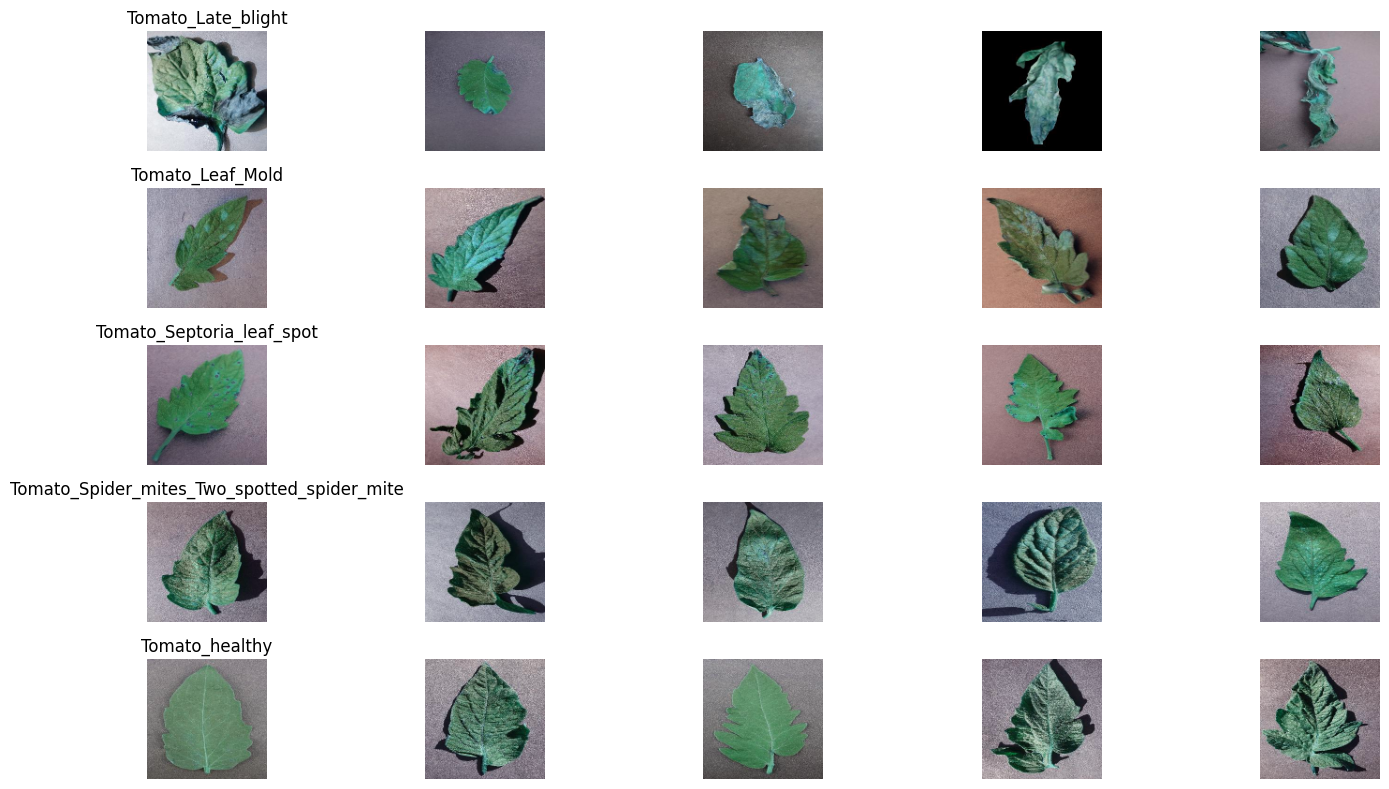


Running SVM Classification with Linear Kernel...

SVM (Linear Kernel) Results:
Accuracy: 0.8126582278481013

Classification Report:
                                             precision    recall  f1-score   support

                         Tomato_Late_blight       0.76      0.84      0.80       376
                           Tomato_Leaf_Mold       0.72      0.66      0.69       189
                  Tomato_Septoria_leaf_spot       0.79      0.79      0.79       337
Tomato_Spider_mites_Two_spotted_spider_mite       0.86      0.87      0.86       335
                             Tomato_healthy       0.91      0.84      0.87       343

                                   accuracy                           0.81      1580
                                  macro avg       0.81      0.80      0.80      1580
                               weighted avg       0.81      0.81      0.81      1580



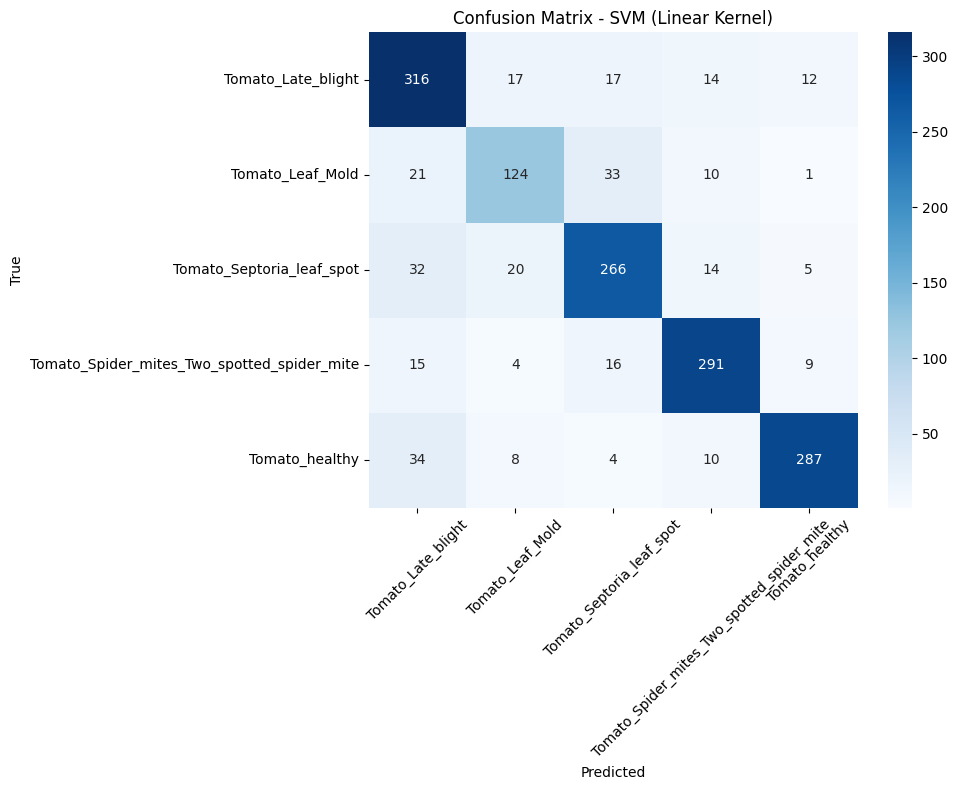


Running SVM Classification with RBF Kernel...


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
import seaborn as sns
from tqdm import tqdm
import os
import cv2

class PlantDiseaseClassifier:
    def __init__(self, data_dir, img_size=(128, 128)):
        self.data_dir = data_dir
        self.img_size = img_size
        self.class_names = []
        self.load_data()
        
    def load_data(self):
        """Load and preprocess plant disease dataset"""
        X, y = [], []
        for class_name in os.listdir(self.data_dir):
            class_path = os.path.join(self.data_dir, class_name)
            if os.path.isdir(class_path):
                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)
                    print(f"Loading image from: {img_path}")  # Debug path
                    img = cv2.imread(img_path)
                    
                    if img is None:
                        print(f"Failed to load image: {img_path}")
                        continue  # Skip this image
                    
                    img = cv2.resize(img, self.img_size)
                    X.append(img)
                    y.append(class_name)
        
        X = np.array(X) / 255.0  # Normalize images
        y = np.array(y)
        self.label_encoder = LabelEncoder()
        y = self.label_encoder.fit_transform(y)
        
        # Split dataset into training and testing sets
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        self.class_names = self.label_encoder.classes_
    
    def visualize_samples(self, num_samples=5):
        """Visualize sample images from each class"""
        plt.figure(figsize=(15, 8))
        for class_idx in range(len(self.class_names)):
            class_images = self.X_train[self.y_train == class_idx]
            for sample_idx in range(min(num_samples, len(class_images))):
                plt.subplot(len(self.class_names), num_samples, class_idx * num_samples + sample_idx + 1)
                plt.imshow(class_images[sample_idx])
                plt.axis('off')
                if sample_idx == 0:
                    plt.title(self.class_names[class_idx])
        plt.tight_layout()
        plt.show()

    class KNNClassifier:
        def __init__(self, k=3):
            self.k = k
            
        def fit(self, X, y):
            self.X_train = X
            self.y_train = y
            
        def predict(self, X):
            predictions = []
            for x in tqdm(X):                  # Calculate distances to all training points
                distances = np.sqrt(np.sum((self.X_train - x)**2, axis=1))
                # Get k nearest neighbors
                k_indices = np.argsort(distances)[:self.k]
                k_nearest_labels = self.y_train[k_indices]
                # Make prediction by majority vote
                prediction = np.bincount(k_nearest_labels).argmax()
                predictions.append(prediction)
            return np.array(predictions)

    class LogisticRegression:
        def __init__(self, learning_rate=0.1, num_iterations=100):
            self.learning_rate = learning_rate
            self.num_iterations = num_iterations
            
        def sigmoid(self, z):
            return 1 / (1 + np.exp(-z))
        
        def fit(self, X, y):
            self.weights = np.zeros(X.shape[1])
            self.bias = 0
            
            for _ in range(self.num_iterations):
                z = np.dot(X, self.weights) + self.bias
                predictions = self.sigmoid(z)
                dz = predictions - y
                dw = np.dot(X.T, dz) / len(y)
                db = np.sum(dz) / len(y)
                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db
                
        def predict(self, X):
            z = np.dot(X, self.weights) + self.bias
            predictions = self.sigmoid(z)
            return (predictions >= 0.5).astype(int)

    class SVMClassifier:
        def __init__(self, kernel='linear', C=1.0, gamma='scale'):
            self.kernel = kernel
            self.C = C
            self.gamma = gamma
            self.model = SVC(kernel=self.kernel, C=self.C, gamma=self.gamma)
            
        def fit(self, X, y):
            self.model.fit(X, y)
            
        def predict(self, X):
            return self.model.predict(X)

    def evaluate_model(self, y_true, y_pred, model_name):
        """Evaluate model performance and display metrics"""
        print(f"\n{model_name} Results:")
        print("Accuracy:", accuracy_score(y_true, y_pred))
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=self.class_names))
        
        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.class_names,
                   yticklabels=self.class_names)
        plt.title(f'Confusion Matrix - {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    def run_experiments(self):
        """Run all classification experiments"""
        
        # # ------------ KNN Classification -------------------#
        # print("\nRunning KNN Classification...")
        # knn = self.KNNClassifier(k=5)
        # knn.fit(self.X_train.reshape(self.X_train.shape[0], -1), self.y_train)
        # knn_predictions = knn.predict(self.X_test.reshape(self.X_test.shape[0], -1))
        # self.evaluate_model(self.y_test, knn_predictions, "KNN")
        
        # # ------------ Logistic Regression -------------------#
        # print("\nRunning Logistic Regression...")
        # log_reg = self.LogisticRegression(learning_rate=0.01, num_iterations=200)
        # log_reg.fit(self.X_train.reshape(self.X_train.shape[0], -1), self.y_train)
        # log_reg_predictions = log_reg.predict(self.X_test.reshape(self.X_test.shape[0], -1))
        # self.evaluate_model(self.y_test, log_reg_predictions, "Logistic Regression")
        
        # ------------ SVM Classification with Linear Kernel -------------------#
        print("\nRunning SVM Classification with Linear Kernel...")
        svm_linear = self.SVMClassifier(kernel='linear', C=1.0)
        svm_linear.fit(self.X_train.reshape(self.X_train.shape[0], -1), self.y_train)
        svm_linear_predictions = svm_linear.predict(self.X_test.reshape(self.X_test.shape[0], -1))
        self.evaluate_model(self.y_test, svm_linear_predictions, "SVM (Linear Kernel)")
        
        # ------------ SVM Classification with RBF Kernel -------------------#
        print("\nRunning SVM Classification with RBF Kernel...")
        svm_rbf = self.SVMClassifier(kernel='rbf', C=3.0, gamma=0.01)
        svm_rbf.fit(self.X_train.reshape(self.X_train.shape[0], -1), self.y_train)
        svm_rbf_predictions = svm_rbf.predict(self.X_test.reshape(self.X_test.shape[0], -1))
        self.evaluate_model(self.y_test, svm_rbf_predictions, "SVM (RBF Kernel)")

if __name__ == "__main__":
    # Path to PlantVillage dataset
    data_dir = r'PlantVillage'  # Fixed path
    
    # Initialize and run the classifier
    classifier = PlantDiseaseClassifier(data_dir)
    
    # Visualize sample images
    print("Visualizing sample images...")
    classifier.visualize_samples()
    
    # Run classification experiments
    classifier.run_experiments()
